In [2]:
import os

import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as pl
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import talib
import yfinance as yf


In [3]:

# Define file paths for the datasets
%matplotlib inline
file_paths = [
    "C:\\Users\\Hasan\\Desktop\\data science folder\\AAPL_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\AMZN_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\GOOG_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\META_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\MSFT_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\NVDA_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\TSLA_historical_data.csv"
]

stock_names = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA", "TSLA"]

# Load datasets and add a 'Stock' column
dataframes = []
for file, stock in zip(file_paths, stock_names):
    df = pd.read_csv(file)
    df['Stock'] = stock  # Add stock name to differentiate
    dataframes.append(df)

# Combine all datasets into a single DataFrame
combined_data = pd.concat(dataframes, ignore_index=True)

# Display basic information
print(combined_data.head())


         Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits Stock  
0        0.0           0.0  AAPL  
1        0.0           0.0  AAPL  
2        0.0           0.0  AAPL  
3        0.0           0.0  AAPL  
4        0.0           0.0  AAPL  


In [4]:
# Combine all datasets
combined_data = pd.concat(dataframes, ignore_index=True)
combined_data.sort_values(by=['Stock', 'Date'], inplace=True)

# Function to calculate financial indicators
def calculate_indicators(df):
    df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
    df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20)
    df['Daily_Return'] = df['Close'].pct_change()
    return df

# Apply indicators
analyzed_data = combined_data.groupby('Stock', group_keys=False).apply(calculate_indicators)

# Save the analyzed data
output_file = "C:\\Users\\Hasan\\Desktop\\data science folder\\analyzed_financial_data.csv"
analyzed_data.to_csv(output_file, index=False)
print(f"Analyzed data saved to {output_file}")


C:\Users\Hasan\AppData\Local\Temp\ipykernel_7384\4014571218.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed_data = combined_data.groupby('Stock', group_keys=False).apply(calculate_indicators)


Analyzed data saved to C:\Users\Hasan\Desktop\data science folder\analyzed_financial_data.csv


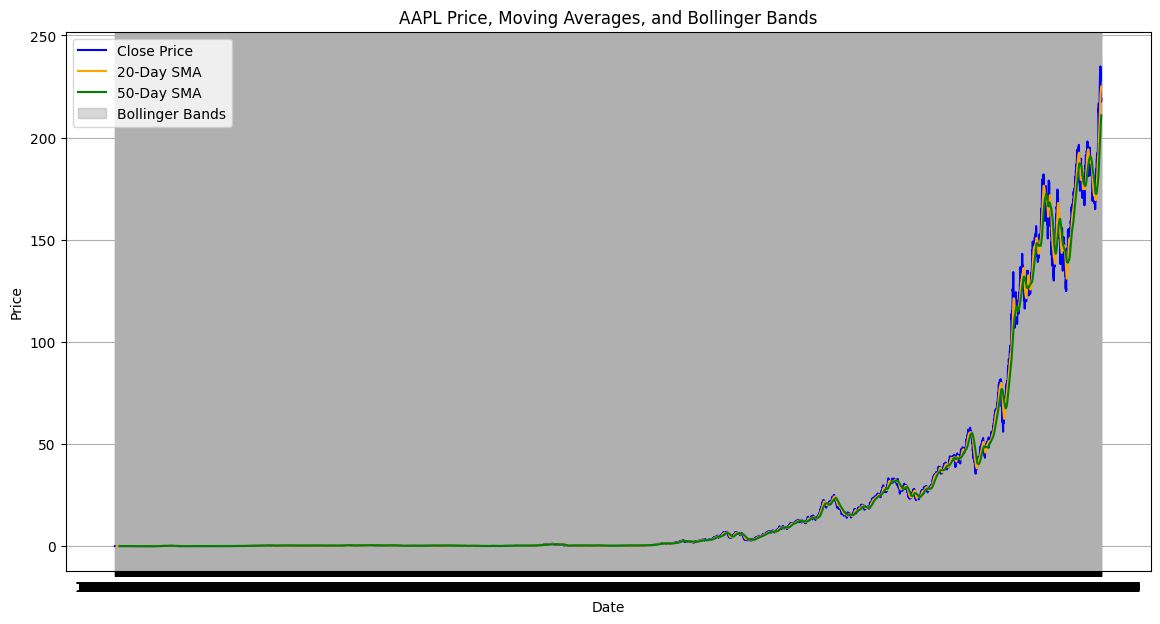

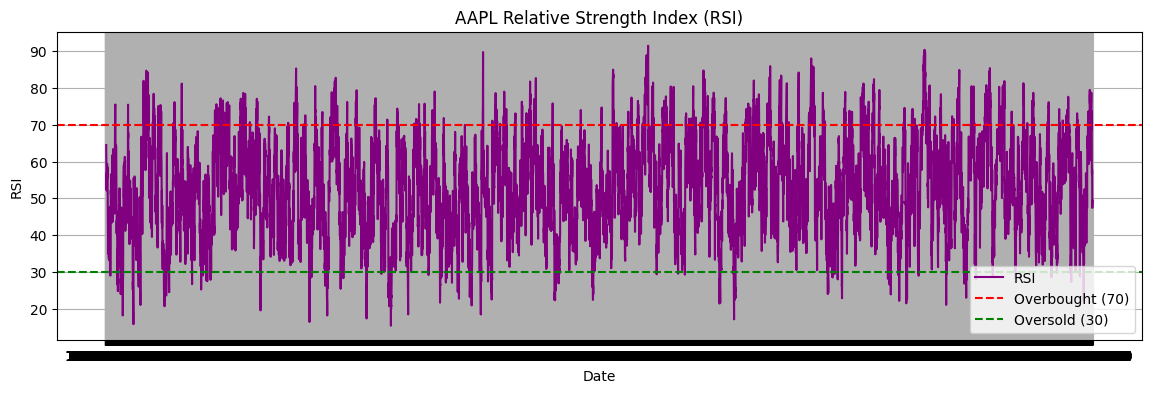

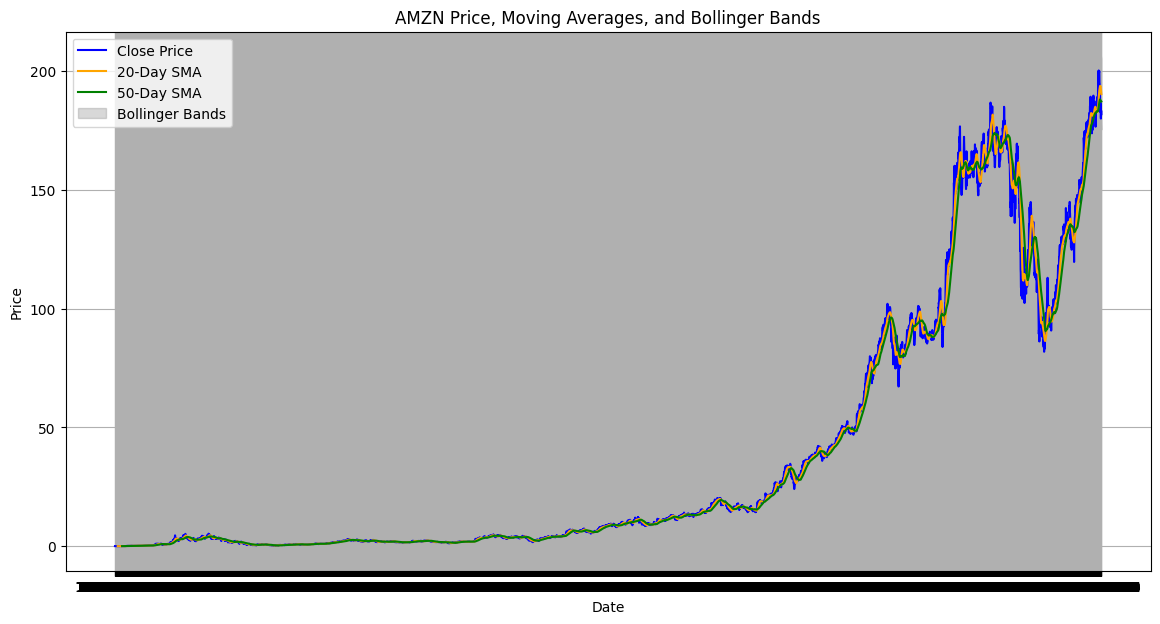

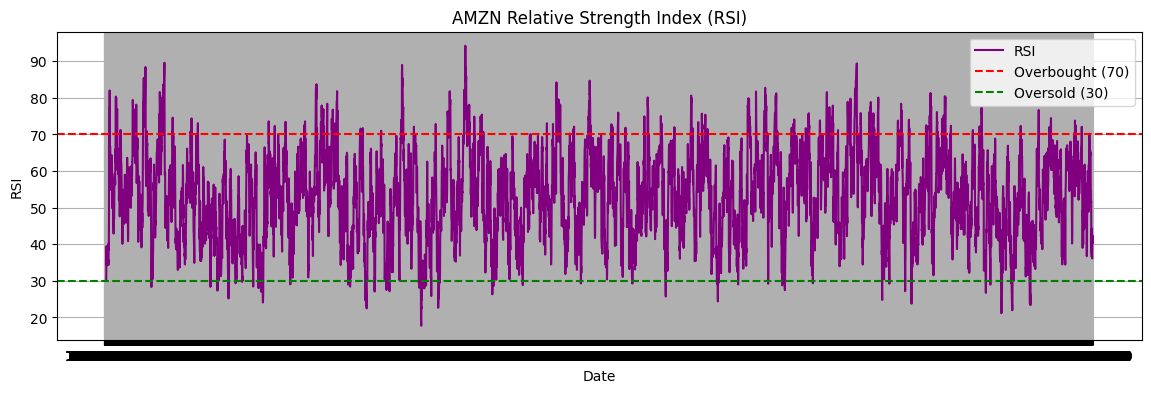

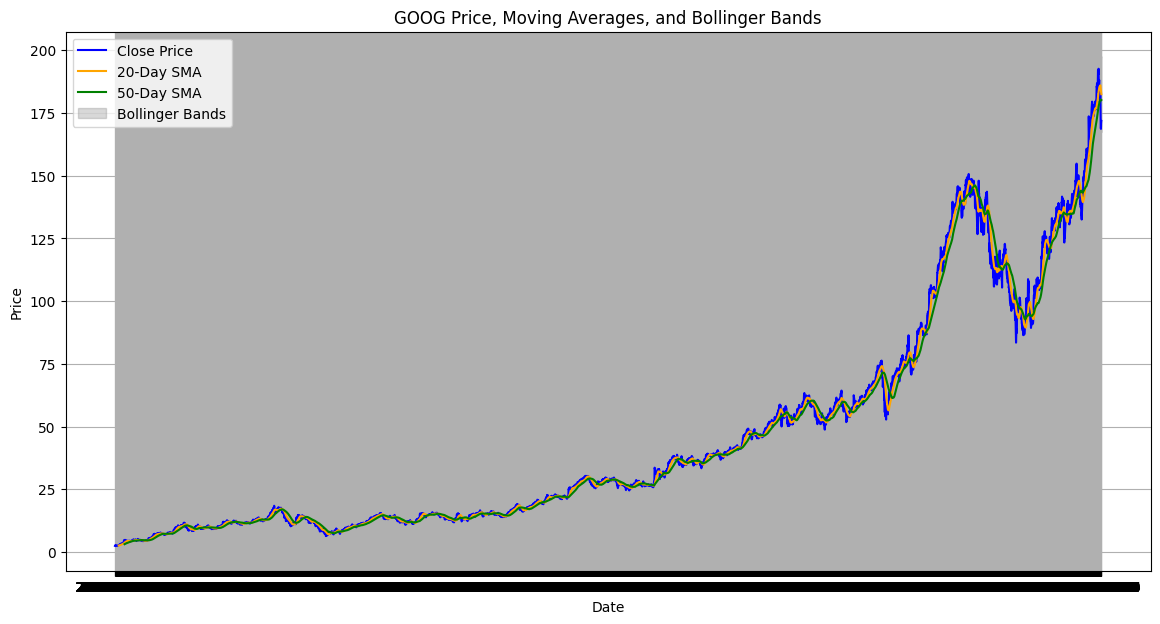

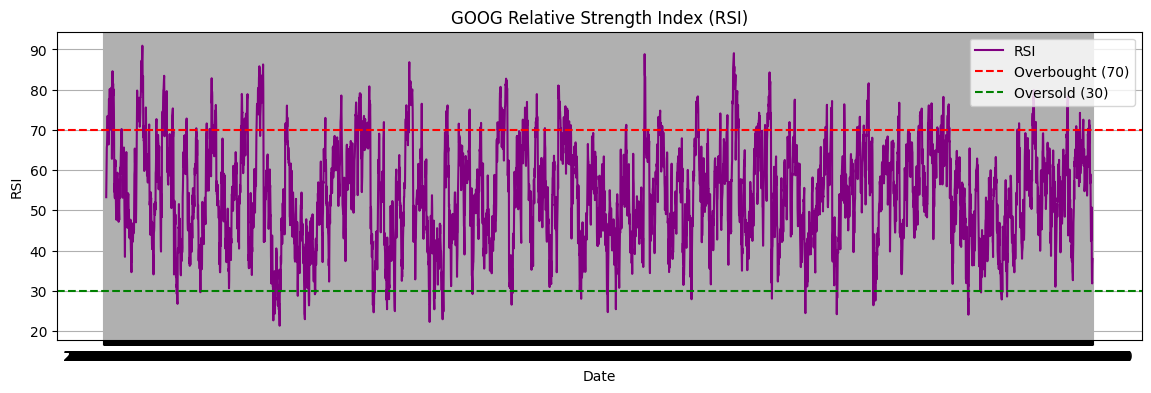

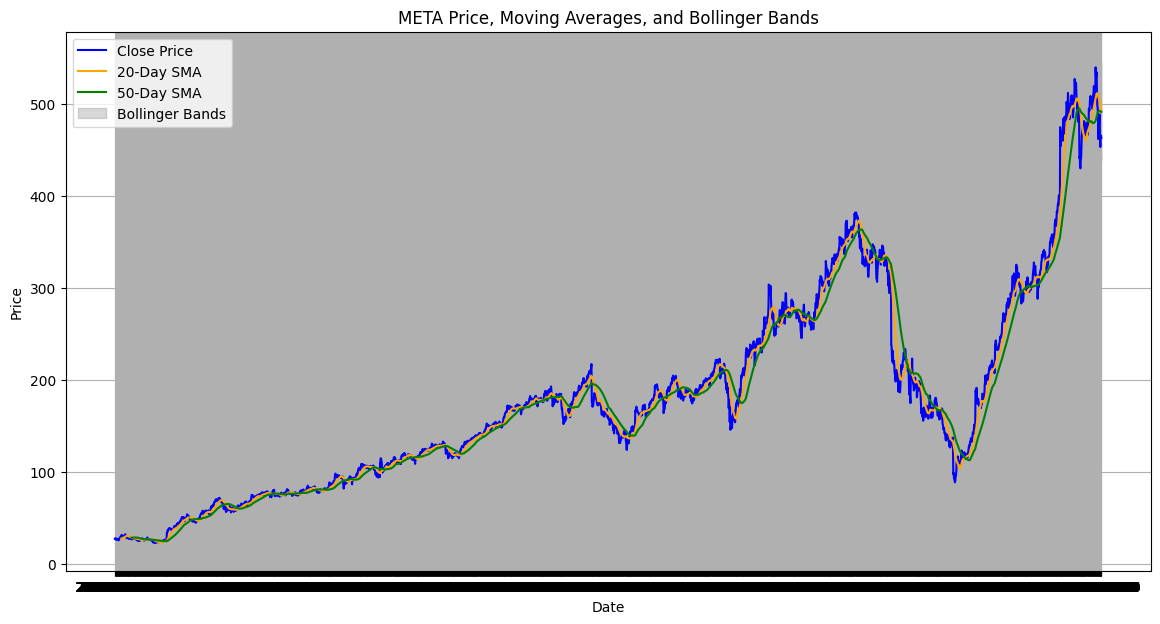

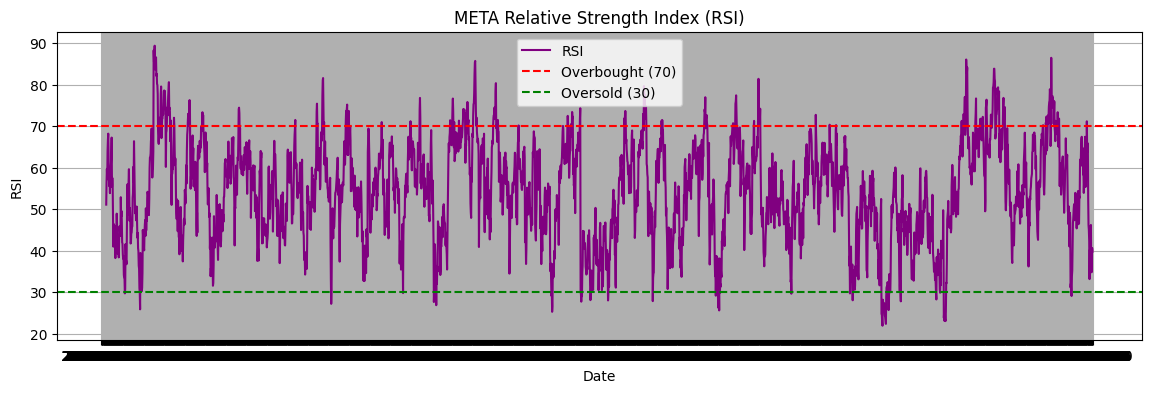

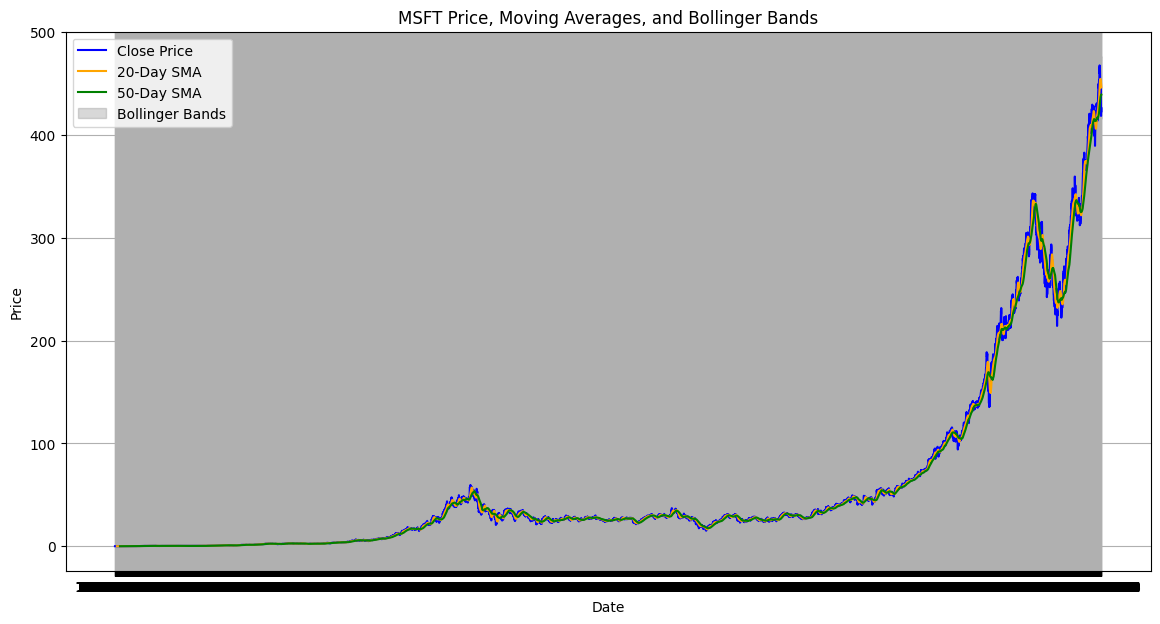

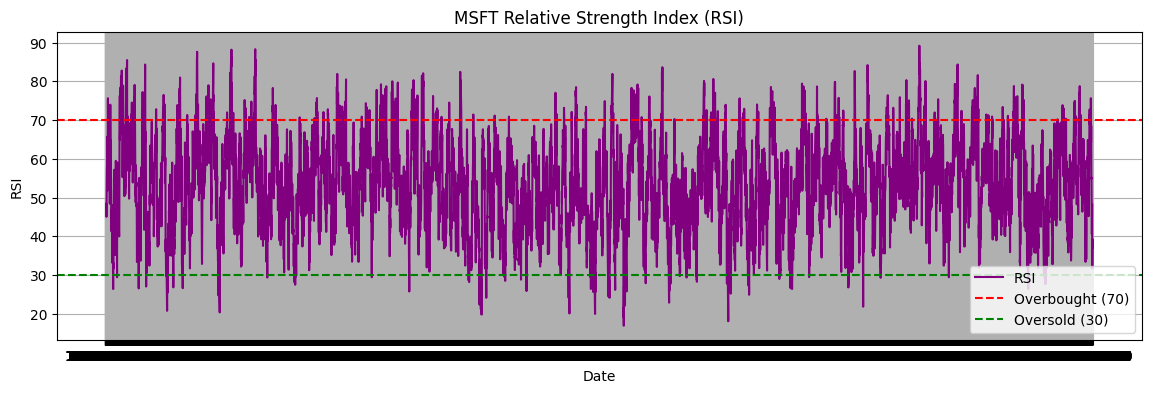

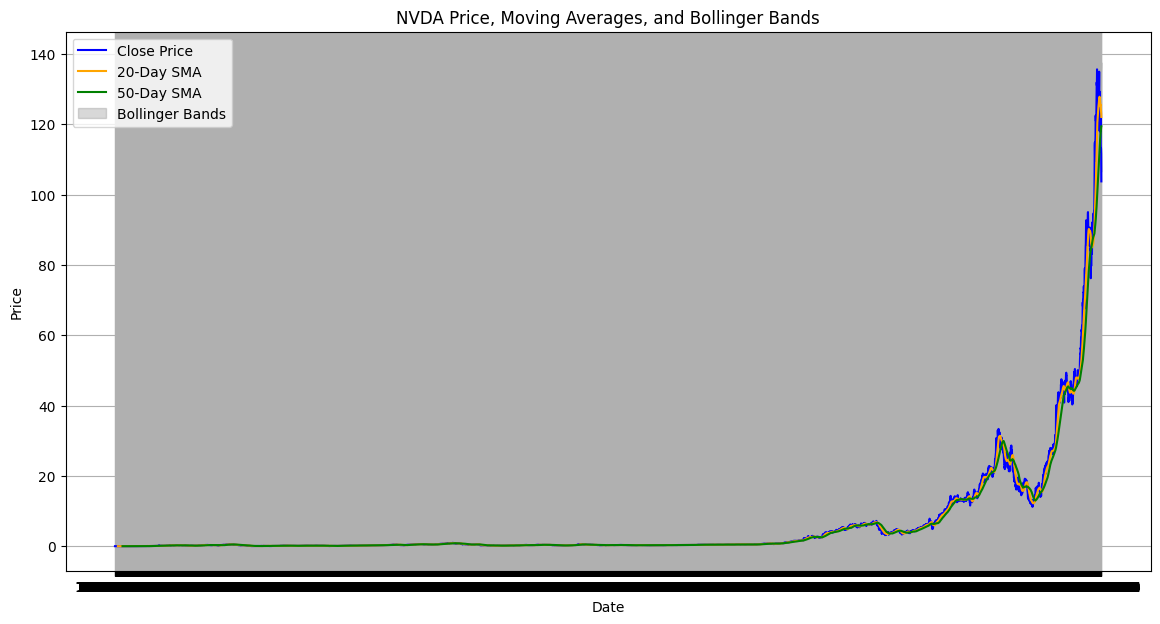

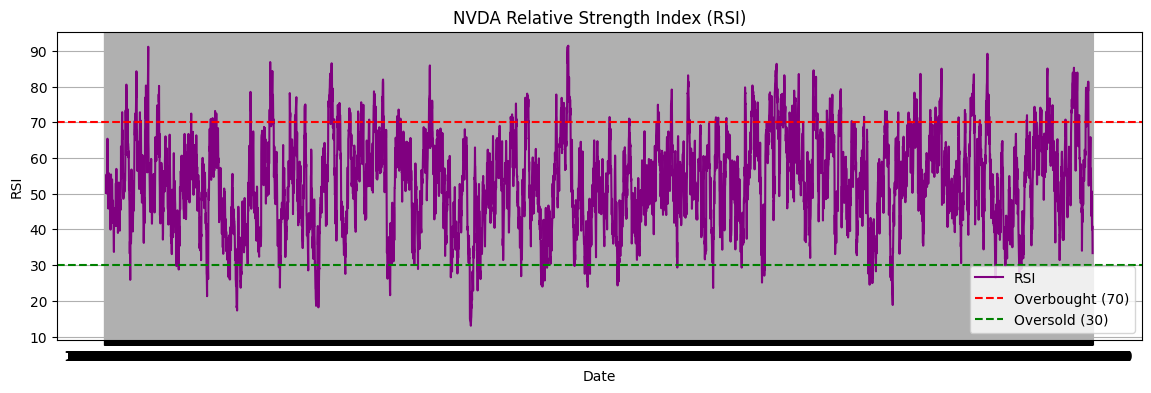

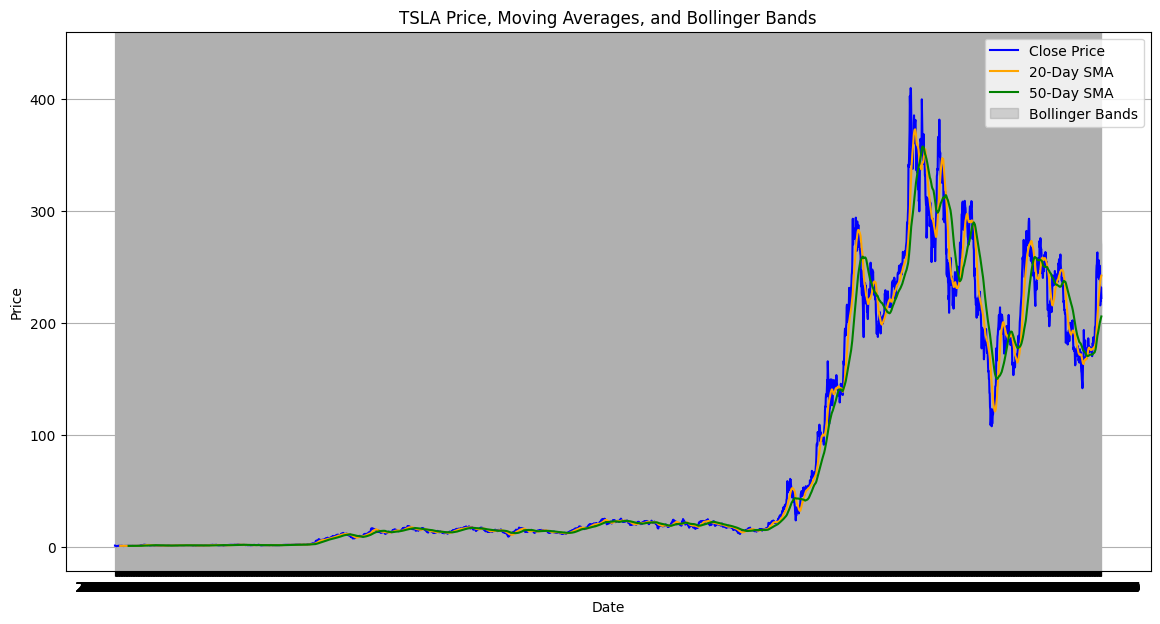

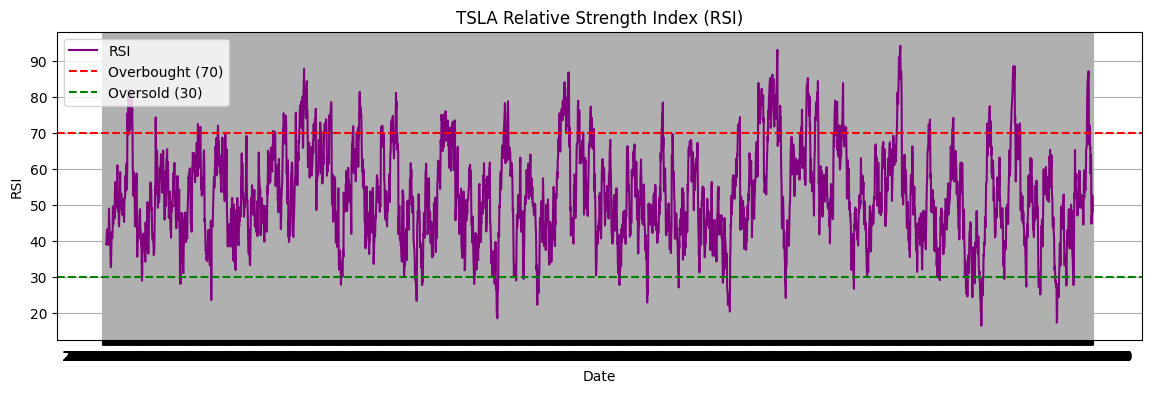


Stock Summary using yfinance:

AAPL Summary:
Current Price: 251.04
52-Week High: 251.3789
52-Week Low: 164.08
Market Cap: 3794670190592

AMZN Summary:
Current Price: 232.93
52-Week High: 233.0
52-Week Low: 144.05
Market Cap: 2449258840064

GOOG Summary:
Current Price: 198.16
52-Week High: 200.64
52-Week Low: 131.55
Market Cap: 2415610036224

META Summary:
Current Price: 624.24
52-Week High: 638.4
52-Week Low: 340.01
Market Cap: 1575887568896

MSFT Summary:
Current Price: 451.59
52-Week High: 468.35
52-Week Low: 366.5
Market Cap: 3357517545472

NVDA Summary:
Current Price: 132.0
52-Week High: 152.89
52-Week Low: 47.32
Market Cap: 3232680116224

TSLA Summary:
Current Price: 463.02
52-Week High: 463.19
52-Week Low: 138.8
Market Cap: 1486322008064


In [5]:
# Visualization
def plot_stock_with_indicators(stock):
    stock_data = analyzed_data[analyzed_data['Stock'] == stock]
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price', color='blue')
    plt.plot(stock_data['Date'], stock_data['SMA_20'], label='20-Day SMA', color='orange')
    plt.plot(stock_data['Date'], stock_data['SMA_50'], label='50-Day SMA', color='green')
    plt.fill_between(stock_data['Date'], stock_data['BB_upper'], stock_data['BB_lower'], color='gray', alpha=0.3, label='Bollinger Bands')
    plt.title(f'{stock} Price, Moving Averages, and Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # RSI
    plt.figure(figsize=(14, 4))
    plt.plot(stock_data['Date'], stock_data['RSI'], color='purple', label='RSI')
    plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    plt.title(f'{stock} Relative Strength Index (RSI)')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid()
    plt.show()

# Plot for each stock
for stock in stock_names:
    plot_stock_with_indicators(stock)

# Fetch summary statistics using yfinance
print("\nStock Summary using yfinance:")
for stock in stock_names:
    ticker = yf.Ticker(stock)
    info = ticker.info
    print(f"\n{stock} Summary:")
    print(f"Current Price: {info.get('currentPrice', 'N/A')}")
    print(f"52-Week High: {info.get('fiftyTwoWeekHigh', 'N/A')}")
    print(f"52-Week Low: {info.get('fiftyTwoWeekLow', 'N/A')}")
    print(f"Market Cap: {info.get('marketCap', 'N/A')}")

In [9]:
news_path = "C:\\Users\\Hasan\\Desktop\\data science folder\\raw_analyst_ratings.csv"
# Load news dataset
news_data = pd.read_csv(news_path)

# Ensure 'Date' column exists and is a datetime object
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')

# Drop rows where Date is invalid
news_data = news_data.dropna(subset=['date'])

print("News data preview:")
print(news_data.head())

News data preview:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                       date stock  
0 2020-06-05 10:30:54-04:00     A  
1 2020-06-03 10:45:20-04:00     A  
2 2020-05-26 

In [20]:

# Load news data
news_data = pd.read_csv("C:\\Users\\Hasan\\Desktop\\data science folder\\raw_analyst_ratings.csv")

# Debugging: Print column names to identify the correct 'Date' column
print("News Data Columns:", news_data.columns)

# Check for column names like 'date', 'DATE', or others and normalize
if 'date' in news_data.columns:
    news_data.rename(columns={'date': 'Date'}, inplace=True)
elif 'DATE' in news_data.columns:
    news_data.rename(columns={'DATE': 'Date'}, inplace=True)
else:
    print("Error: No 'Date' column found in the news dataset.")
    raise KeyError("No column named 'Date' in the dataset.")

# Convert 'Date' column to datetime
news_data['Date'] = pd.to_datetime(news_data['Date'], errors='coerce')

# Drop invalid dates
news_data.dropna(subset=['Date'], inplace=True)

# Preview the cleaned news data
print(news_data.head())


News Data Columns: Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                       Date stock 

In [24]:
# Check the date range for stock data
print("Stock Data Date Range:")
print(combined_data['Date'].min(), combined_data['Date'].max())

# Check the date range for news data
print("News Data Date Range:")
print(news_data['Date'].min(), news_data['Date'].max())

# Inspect a sample of the dates
print("Sample Dates from Stock Data:")
print(combined_data['Date'].dropna().sort_values().unique()[:10])

print("Sample Dates from News Data:")
print(news_data['Date'].dropna().sort_values().unique()[:10])


Stock Data Date Range:
1980-12-12 00:00:00 2024-07-30 00:00:00
News Data Date Range:
2011-04-27 21:01:48 2020-06-11 17:12:35
Sample Dates from Stock Data:
<DatetimeArray>
['1980-12-12 00:00:00', '1980-12-15 00:00:00', '1980-12-16 00:00:00',
 '1980-12-17 00:00:00', '1980-12-18 00:00:00', '1980-12-19 00:00:00',
 '1980-12-22 00:00:00', '1980-12-23 00:00:00', '1980-12-24 00:00:00',
 '1980-12-26 00:00:00']
Length: 10, dtype: datetime64[ns]
Sample Dates from News Data:
<DatetimeArray>
['2011-04-27 21:01:48', '2011-04-28 13:49:29', '2011-04-28 15:00:36',
 '2011-04-29 13:47:06', '2011-04-29 16:11:05', '2011-04-30 16:52:35',
 '2011-05-01 18:18:28', '2011-05-02 02:17:31', '2011-05-02 03:24:46',
 '2011-05-02 14:16:40']
Length: 10, dtype: datetime64[ns]


In [25]:
# Filter stock data to the news data date range
stock_data_filtered = combined_data[
    (combined_data['Date'] >= news_data['Date'].min()) & 
    (combined_data['Date'] <= news_data['Date'].max())
]

print("Filtered Stock Data Date Range:")
print(stock_data_filtered['Date'].min(), stock_data_filtered['Date'].max())

# Check the filtered stock data
print(stock_data_filtered.head())


Filtered Stock Data Date Range:
2011-04-28 00:00:00 2020-06-11 00:00:00
           Date       Open       High        Low      Close  Adj Close  \
7663 2011-04-28  12.363929  12.491071  12.340000  12.383929  10.457921   
7664 2011-04-29  12.385000  12.641071  12.381071  12.504643  10.559862   
7665 2011-05-02  12.490714  12.516786  12.339286  12.367143  10.443746   
7666 2011-05-03  12.428214  12.496071  12.343571  12.435714  10.501650   
7667 2011-05-04  12.437857  12.565357  12.388571  12.484643  10.542973   

          Volume  Dividends  Stock Splits Stock  
7663   360959200        0.0           0.0  AAPL  
7664  1006345200        0.0           0.0  AAPL  
7665   442713600        0.0           0.0  AAPL  
7666   313348000        0.0           0.0  AAPL  
7667   389250400        0.0           0.0  AAPL  


In [27]:
#for Corelation merge the news and stock data using date
# Standardize both Date columns to remove timestamps (keep only the date)
stock_data_filtered['Date'] = stock_data_filtered['Date'].dt.date
news_data['Date'] = news_data['Date'].dt.date

# Convert both 'Date' columns back to datetime objects for consistency
stock_data_filtered['Date'] = pd.to_datetime(stock_data_filtered['Date'])
news_data['Date'] = pd.to_datetime(news_data['Date'])

# Merge datasets again on 'Date'
aligned_data = pd.merge(stock_data_filtered, news_data, on='Date', how='inner')

# Check the result
print("Aligned Data Sample:")
print(aligned_data.head())

print("Aligned Data Shape:", aligned_data.shape)


C:\Users\Hasan\AppData\Local\Temp\ipykernel_7384\968911137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered['Date'] = stock_data_filtered['Date'].dt.date
C:\Users\Hasan\AppData\Local\Temp\ipykernel_7384\968911137.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_filtered['Date'] = pd.to_datetime(stock_data_filtered['Date'])


Aligned Data Sample:
        Date       Open       High        Low      Close  Adj Close  \
0 2011-04-28  12.363929  12.491071  12.340000  12.383929  10.457921   
1 2011-04-28  12.363929  12.491071  12.340000  12.383929  10.457921   
2 2011-04-29  12.385000  12.641071  12.381071  12.504643  10.559862   
3 2011-04-29  12.385000  12.641071  12.381071  12.504643  10.559862   
4 2011-05-02  12.490714  12.516786  12.339286  12.367143  10.443746   

       Volume  Dividends  Stock Splits Stock  Unnamed: 0  \
0   360959200        0.0           0.0  AAPL      350150   
1   360959200        0.0           0.0  AAPL      437774   
2  1006345200        0.0           0.0  AAPL       49280   
3  1006345200        0.0           0.0  AAPL      539428   
4   442713600        0.0           0.0  AAPL       46024   

                                            headline  \
0  Dejour Extends Credit Facility to October 31st...   
1                A New Regional Emerging Markets ETF   
2        ETF Showdown: 

In [28]:
# Define a function to get sentiment
def get_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return 0.0  # Neutral if no text
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to headlines
aligned_data['sentiment'] = aligned_data['headline'].apply(get_sentiment)

# Classify sentiment into positive, neutral, and negative
def classify_sentiment(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

aligned_data['sentiment_label'] = aligned_data['sentiment'].apply(classify_sentiment)

# Check the results
print("Sentiment Analysis Results:")
print(aligned_data[['headline', 'sentiment', 'sentiment_label']].head())


Sentiment Analysis Results:
                                            headline  sentiment  \
0  Dejour Extends Credit Facility to October 31st...   0.000000   
1                A New Regional Emerging Markets ETF   0.136364   
2        ETF Showdown: Crouching Tigers, Hidden ETFs  -0.166667   
3  The GDL Fund to Redeem Its Outstanding 8.50% S...   0.500000   
4              ETF Securities Reportedly Mulling IPO   0.000000   

  sentiment_label  
0         neutral  
1        positive  
2        negative  
3        positive  
4         neutral  


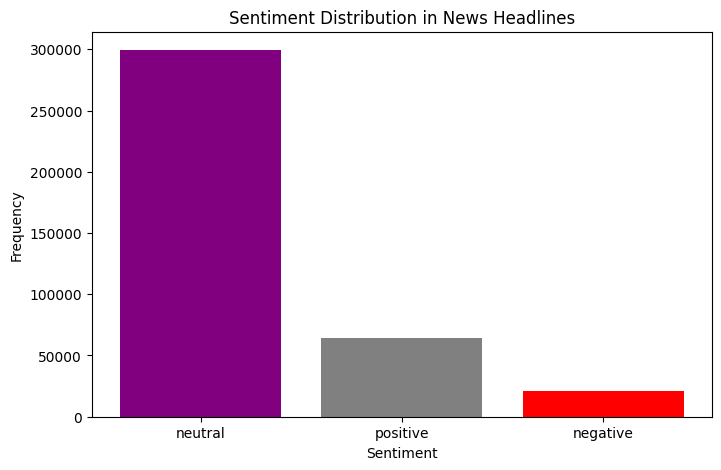

In [30]:
# Plot sentiment distribution
sentiment_counts = aligned_data['sentiment_label'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['Purple', 'grey', 'red'])
plt.title('Sentiment Distribution in News Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()


In [31]:
# Assuming 'Close' is the column containing daily closing prices in aligned_data

# Calculate Daily Stock Returns as percentage change
aligned_data['Daily Return'] = aligned_data['Close'].pct_change() * 100

# Display the updated DataFrame with Daily Returns
print("Aligned Data with Daily Stock Returns:")
print(aligned_data.head())

# Optional: Check for missing values or irregularities
print("Daily Returns Calculated Successfully.")


Aligned Data with Daily Stock Returns:
        Date       Open       High        Low      Close  Adj Close  \
0 2011-04-28  12.363929  12.491071  12.340000  12.383929  10.457921   
1 2011-04-28  12.363929  12.491071  12.340000  12.383929  10.457921   
2 2011-04-29  12.385000  12.641071  12.381071  12.504643  10.559862   
3 2011-04-29  12.385000  12.641071  12.381071  12.504643  10.559862   
4 2011-05-02  12.490714  12.516786  12.339286  12.367143  10.443746   

       Volume  Dividends  Stock Splits Stock  Unnamed: 0  \
0   360959200        0.0           0.0  AAPL      350150   
1   360959200        0.0           0.0  AAPL      437774   
2  1006345200        0.0           0.0  AAPL       49280   
3  1006345200        0.0           0.0  AAPL      539428   
4   442713600        0.0           0.0  AAPL       46024   

                                            headline  \
0  Dejour Extends Credit Facility to October 31st...   
1                A New Regional Emerging Markets ETF   
2    

In [33]:
# Merge the datasets
aligned_data = pd.merge(stock_data_filtered, news_data, on='Date', how='inner')

# Display the columns
print("Columns in merged dataset:", aligned_data.columns)


Columns in merged dataset: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Stock', 'Unnamed: 0', 'headline', 'url',
       'publisher', 'stock'],
      dtype='object')


In [34]:

# Define a function to calculate sentiment polarity
def calculate_sentiment(text):
    if pd.isna(text):
        return 0  # Neutral sentiment for missing headlines
    return TextBlob(text).sentiment.polarity  # Polarity ranges from -1 (negative) to 1 (positive)

# Apply the function to the 'headline' column
aligned_data['Sentiment'] = aligned_data['headline'].apply(calculate_sentiment)

# Check the updated dataset
print("Dataset with Sentiment Scores:")
print(aligned_data[['Date', 'headline', 'Sentiment']].head())

Dataset with Sentiment Scores:
        Date                                           headline  Sentiment
0 2011-04-28  Dejour Extends Credit Facility to October 31st...   0.000000
1 2011-04-28                A New Regional Emerging Markets ETF   0.136364
2 2011-04-29        ETF Showdown: Crouching Tigers, Hidden ETFs  -0.166667
3 2011-04-29  The GDL Fund to Redeem Its Outstanding 8.50% S...   0.500000
4 2011-05-02              ETF Securities Reportedly Mulling IPO   0.000000


In [35]:
# Ensure 'aligned_data' has Date and Sentiment columns
print("Columns in merged dataset:", aligned_data.columns)

# Group by Date and compute the average sentiment
average_sentiment = aligned_data.groupby('Date', as_index=False)['Sentiment'].mean()

# Rename the column for clarity
average_sentiment.rename(columns={'Sentiment': 'Average Sentiment'}, inplace=True)

# Merge the average sentiment back into the original aligned_data (optional step)
aligned_data = pd.merge(aligned_data, average_sentiment, on='Date', how='left')

# Drop duplicates if necessary
aligned_data = aligned_data.drop_duplicates()

# Display the updated dataset
print("Updated Merged Dataset with Average Sentiment:")
print(aligned_data.head())

Columns in merged dataset: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Stock', 'Unnamed: 0', 'headline', 'url',
       'publisher', 'stock', 'Sentiment'],
      dtype='object')
Updated Merged Dataset with Average Sentiment:
        Date       Open       High        Low      Close  Adj Close  \
0 2011-04-28  12.363929  12.491071  12.340000  12.383929  10.457921   
1 2011-04-28  12.363929  12.491071  12.340000  12.383929  10.457921   
2 2011-04-29  12.385000  12.641071  12.381071  12.504643  10.559862   
3 2011-04-29  12.385000  12.641071  12.381071  12.504643  10.559862   
4 2011-05-02  12.490714  12.516786  12.339286  12.367143  10.443746   

       Volume  Dividends  Stock Splits Stock  Unnamed: 0  \
0   360959200        0.0           0.0  AAPL      350150   
1   360959200        0.0           0.0  AAPL      437774   
2  1006345200        0.0           0.0  AAPL       49280   
3  1006345200        0.0           0.0  AAPL  

In [40]:

from scipy.stats import pearsonr

# Check for missing values and drop rows with NaNs in relevant columns
aligned_data = aligned_data.dropna(subset=['Adj Close', 'Sentiment'])

# Calculate Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(aligned_data['Adj Close'], aligned_data['Sentiment'])

# Display the correlation result
print("Correlation Analysis between Daily Returns and News Sentiment:")
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The correlation is statistically significant at the 5% level.")
else:
    print("The correlation is not statistically significant.")


Correlation Analysis between Daily Returns and News Sentiment:
Pearson Correlation Coefficient: -0.0058
P-Value: 0.0004
The correlation is statistically significant at the 5% level.


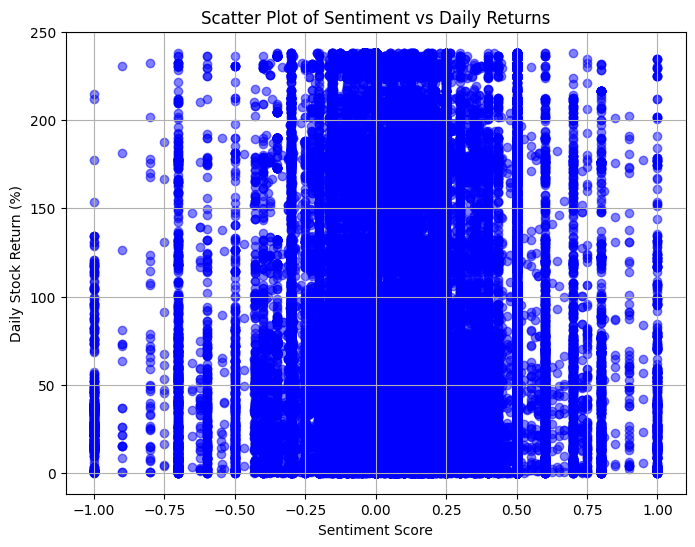

In [42]:
# Scatter plot of Sentiment vs Daily Returns
plt.figure(figsize=(8, 6))
plt.scatter(aligned_data['Sentiment'], aligned_data['Adj Close'], color='blue', alpha=0.5)
plt.title("Scatter Plot of Sentiment vs Daily Returns")
plt.xlabel("Sentiment Score")
plt.ylabel("Daily Stock Return (%)")
plt.grid()
plt.show()
